In [1]:
import numpy as np
import scipy.stats

import os
import re

import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.multitest

import csv
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from patsy import Sum


In [2]:
%matplotlib inline

In [3]:
# Define file paths
data_dir = '../data'
pupil_dir = '../data/SingleTrialPupilData'
eeg_dir = '../data/SingleTrialEEGData'
plot_dir = '../plots'

include:
- theta: frontal & central
- alpha: central & parietal
- beta: central & parietal

exclude:
-  trials with no eeg
-  trials with no pain data
    - P05: block 3 & 4
    - P14: last trials of block 3 & all of block 4

# Model Fitting

Skip if loading previously fitted data

In [ ]:
files_pupil = os.listdir(pupil_dir)
files_eeg = os.listdir(eeg_dir)

In [ ]:
all_tonic_sides = pd.read_csv(os.path.join(data_dir, 'tonicpainsides.csv'))

In [ ]:
def function(lr, file, V_0):

    """
    Updates and computes the correlation between V values and mean EEG frequency data.
    
    Parameters:
        - lr (float): 
            Learning rate for updating V values.
        - file (str): 
            Filename of the pupil data CSV.
        - V_0 (list or array): 
            Initial V values.
    
    Returns:
        float: Negative Pearson correlation coefficient between updated V values and mean EEG frequencies.
    """
    
    # Extract participant identifier from the filename
    res = re.search('(...)_PupilDiameterProcessed', file)
    participant = res.group(1)

    # Find corresponding EEG file for the participant
    match_eeg = [s for s in files_eeg if participant in s]

    # Load pupil and EEG data
    df_pupil = pd.read_csv(os.path.join(pupil_dir, file))
    df_eeg = pd.read_csv(os.path.join(eeg_dir, match_eeg[0]))

    # Calculate the cumulative number of trials up to each block
    block_1 = np.sum(df_eeg['Block'] == 1)
    block_2 = block_1 + np.sum(df_eeg['Block'] == 2)
    block_3 = block_2 + np.sum(df_eeg['Block'] == 3)
    block_4 = block_3 + np.sum(df_eeg['Block'] == 4)

    # Recode 'side' as numerical values
        # 'side' refers to the direction of the rock
    df_eeg['side'] = (df_eeg['type']== 'left') * 0 + \
        (df_eeg['type']== 'middle') * 1 + \
        (df_eeg['type']== 'right') * 2

     # Compute mean frequency across specified frequency bands
    df_eeg['mean'] = np.mean(df_eeg.loc[:, freq_include], axis = 1)

    # Initialize V values and array to store V values for each trial
    V = np.array((V_0))                 
    all_V = np.zeros((np.shape(df_eeg)[0] + 1, 3))
    all_V[0, :] = V
                           
    # Calculate V values for each trial across blocks
    for block in [1,2,3,4]:

        # Skip block 3 for participant 5, as pain values are missing
        if participant == 'P05' and (block == 3 or block == 4):
            continue
        if participant == 'P14' and block == 4:
            continue
        
        # Get data for block
        this_block = df_eeg[df_eeg['Block'] == block]
        
        for i_t, trial in enumerate(this_block['epoch']):
            if participant == 'P14' and trial>241:
                continue
            # Determine cue side based on 'type'
            if this_block.loc[trial-1, 'type'] == 'left':
                cue_side = 0
            elif this_block.loc[trial-1, 'type'] == 'middle':
                cue_side = 1
            elif this_block.loc[trial-1, 'type'] == 'right':
                cue_side = 2
            else:
                print('Error: Unrecognized cue side.')

            # Determine reward value based on 'pain'
            if this_block.loc[trial-1,'pain'] == 'PCollShock':
                r = 1
            elif this_block.loc[trial-1,'pain'] == 'nPCollNoShock':
                r = 0
            elif this_block.loc[trial-1,'pain'] == 'PCollNoShock':
                r = 0
            elif np.logical_and(np.isnan(this_block.loc[trial-1,'pain']), block == 2 or block == 4):
                r = 0
            else:
                if this_block.loc[trial-1, 'type'] == 'middle':
                    r = 0
                else:
                    r = 1

            # Update V
            V[cue_side] = V[cue_side] * (1 - lr) + lr * r
            all_V[trial, :] = V
   
    # Create a boolean mask for rows where 'Include' column equals 1 (used for filtering EEG data). Change mask to exclude the last trial. This is because, we want to correlate the V-value before the trial to the eeg data
    V_incl = (df_eeg['Include'] == 1)
    V_incl[-1] = False

    # Create a boolean mask for rows where 'Include' column equals 1 (used for filtering EEG data)
    eeg_incl = (df_eeg['Include'] == 1)

    # Exclude the last trials for participant 5 and 14, as pain values are missing
    if participant == 'P05':
        eeg_incl[180::] = False
        V_incl[180::] = False
    elif participant == 'P14':
        eeg_incl[241::] = False
        V_incl[241::] = False

    # Calculate the Pearson correlation coefficient between:
    # 1. The values in `all_V` corresponding to the V-values of the side from which the rock is approaching in that trial.
    # 2. The mean EEG frequencies 
    # for the rows where 'Include' is 1
    correlation = scipy.stats.pearsonr(
            all_V[V_incl, df_eeg.loc[eeg_incl, 'side']],
            df_eeg['mean'].loc[eeg_incl])[0]

    return (-correlation)

In [ ]:
# Define boundary constraints for optimization. 
# Lower bound (lb) is set to 0.0 and upper bound (ub) is set to 1.0.
bnds = scipy.optimize.Bounds(lb=0.01, ub=0.99)

# List of frequency variables to include in the optimization or analysis.
# These variables seem represent frequency band for different 
# electrode locations (el1, el2, el3) and timebins (t1, t2, t3).
freq_include = ['Freq_f1_t1_el1', 'Freq_f1_t2_el1', 'Freq_f1_t3_el1',
           'Freq_f1_t1_el2', 'Freq_f1_t2_el2', 'Freq_f1_t3_el2',
           'Freq_f2_t1_el2', 'Freq_f2_t2_el2', 'Freq_f2_t3_el2',
           'Freq_f2_t1_el3', 'Freq_f2_t2_el3', 'Freq_f2_t3_el3',
           'Freq_f3_t1_el2', 'Freq_f3_t2_el2', 'Freq_f3_t3_el2',
           'Freq_f3_t1_el3', 'Freq_f3_t2_el3', 'Freq_f3_t3_el3']


In [ ]:
# Intialize DataFrame to save relevant trial data (EEG, V values, participant ID, and congruency)
all_data = pd.DataFrame()

# Intialize DataFrame to save relevant model fitting data (ID, learning rate, maximum correlation)
df_model = pd.DataFrame()

for i_file, file in enumerate(files_pupil):
    print('========= \n File : {} of {}'.format(i_file + 1, len(files_pupil)))
    try:
        # Initialize V Values for RL
        V_0 = np.array((1/3, 1/3, 1/3))

        # Extract the participant ID from the file name
        ID = int(re.split('_PupilDiameterProcessed_ST.csv', file)[0][1::])

        # Extract the tonic pain sides for the participant
        tonic_sides  = all_tonic_sides.loc[all_tonic_sides['ID'] == ID, 'Extn1' : 'Extn2'].values[0].astype('str')
        tonic_sides[np.where(tonic_sides == '1')] = 'left'
        tonic_sides[np.where(tonic_sides == '2')] = 'right'
        
        # Fit the model
        fit_res = scipy.optimize.minimize(function, (0.5, ), args=(file, V_0), method= 'SLSQP', bounds = bnds)
        print(fit_res.message)
        
        # Extract participant identifier from the filename
        res_file = re.search('(...)_PupilDiameterProcessed', file)
        participant = res_file.group(1)

        # Find corresponding EEG file for the participant
        match_eeg = [s for s in files_eeg if participant in s]

        # Load pupil and EEG data
        df_pupil = pd.read_csv(os.path.join(pupil_dir, file))
        df_eeg = pd.read_csv(os.path.join(eeg_dir, match_eeg[0]))


        # Recode 'side' as numerical values
            # 'side' refers to the direction of the rock
        df_eeg['side'] = (df_eeg['type']== 'left') * 0 + \
            (df_eeg['type']== 'middle') * 1 + \
            (df_eeg['type']== 'right') * 2

        # Initialize V values
        V = np.array((V_0))
        all_V = np.zeros((np.shape(df_eeg)[0] + 1, 3))
        all_V[0, :] = V
    
        # Save learning rate from model fit
        lr = fit_res.x
        
        # Loop through each block (1 to 4)
        for block in [1,2,3,4]:
            
            # Skip block 3 for participant 5, as pain values are missing
            if ID == 5 and (block == 3 or block == 4):
                print('Skipping block 3 and 4 for participant 5')
                continue
            if ID == 14 and block == 4:
                print('Skipping block 4 for participant 14')
                continue

            # Extract data for this block
            this_block = df_eeg[df_eeg['Block'] == block]
            
             # Loop through each trial in the block
            for i_t, trial in enumerate(this_block['epoch']):
                
                if ID == 14 and trial>241:
                    print('Skipping trial {} in block 3 for participant 14'.format(trial))
                    continue
                
                # Determine the cue side for the current trial (left, middle, right)
                if this_block.loc[trial-1, 'type'] == 'left':
                    cue_side = 0
                elif this_block.loc[trial-1, 'type'] == 'middle':
                    cue_side = 1
                elif this_block.loc[trial-1, 'type'] == 'right':
                    cue_side = 2
                else:
                    print('Error: Unrecognized cue side.')

                # Determine reward based on 'pain' value
                if this_block.loc[trial-1,'pain'] == 'PCollShock':
                    r = 1
                elif this_block.loc[trial-1,'pain'] == 'nPCollNoShock':
                    r = 0
                elif this_block.loc[trial-1,'pain'] == 'PCollNoShock':
                    r = 0
                elif np.logical_and(np.isnan(this_block.loc[trial-1,'pain']), block == 2 or block == 4):
                    r = 0
                else:
                    print('Error: Unrecognized pain value: {}'.format(this_block.loc[trial-1,'pain']))
                    if this_block.loc[trial-1, 'type'] == 'middle':
                        r = 0
                    else:
                        r = 1
                    
                # Update V based on reward and learning rate
                V[cue_side] = V[cue_side] * (1 - lr) + lr * r
                all_V[trial, :] = V
        
        # Create masks for trials to include
        V_inc = (df_eeg['Include'] == 1)
        V_inc[np.shape(V_inc)[0] + 1] = False # Exclude the last row
        eeg_incl = (df_eeg['Include'] == 1)

        # Exclude the last trials for participant 5 and 14, as pain values are missing
        if participant == 'P05':
            eeg_incl[180::] = False
            V_inc[180::] = False
        elif participant == 'P14':
            eeg_incl[241::] = False
            V_inc[241::] = False

        # Create a DataFrame for the V values for the included trials
        df_V = pd.DataFrame(all_V[
            V_inc, 
            df_eeg.loc[eeg_incl, 'side']],
            columns = ['V'])
                            
        # Create a DataFrame for the participant ID (repeated for each trial)
        df_ID = pd.DataFrame(np.repeat(ID, np.shape(df_V)[0]), columns = ['ID'])
        
        # Filter EEG data for included trials
        df_eeg_inc = df_eeg.loc[eeg_incl, freq_include].reset_index(drop = True)
        
        # Identify congruent and incongruent trials based on block and side information
        cong = np.logical_or(
            np.logical_and(df_eeg['Block'] == 2, df_eeg['type'] == tonic_sides[0]),
            np.logical_and(df_eeg['Block'] == 4, df_eeg['type'] == tonic_sides[1]))
        incong = np.logical_or(
            np.logical_and(df_eeg['Block'] == 2, df_eeg['type'] == tonic_sides[1]),
            np.logical_and(df_eeg['Block'] == 4, df_eeg['type'] == tonic_sides[0]))

        # Create a DataFrame for congruency information (congruent or incongruent on extinction blocks; nan for acquisition blocks)
        df_congr = (np.ones((np.shape(df_eeg)[0])) * np.nan).astype('str')
        df_congr[cong] = "congr" # congruent trials
        df_congr[incong] = "incongr" # incongruent trials
        
        # Filter congruency data for included trials
        df_congr = pd.DataFrame(df_congr[eeg_incl], columns = ['congruency'])
                
        # Concatenate the relevant data (EEG, V values, participant ID, and congruency) into a new row
        new_row = pd.concat([df_eeg_inc,df_V, df_ID, df_congr], axis = 1)
        
        # Append the new row to the overall data
        all_data = pd.concat([all_data, new_row])

        # Append the model fitting data
        df_model = pd.concat([df_model, pd.DataFrame({'ID': ID, 'lr': lr, 'max_corr': -fit_res.fun})])
    
    except:
        # Print error message if something goes wrong during file processing
        print('__something went wrong')

# Reset index of the final DataFrame
all_data.reset_index(drop = True)

print('DONE')

In [ ]:
df_model.to_csv(os.path.join(data_dir, 'eeg_model_fitting_results.csv'), index = False)

In [ ]:
all_data.to_csv(os.path.join(data_dir, 'eeg_v_values.csv'), index = False)

# Load Data

In [5]:
# Read csv file into DataFrame
all_data = pd.read_csv(os.path.join(data_dir, 'eeg_v_values.csv'))

# Regression

In [6]:
# Reshape the 'all_data' DataFrame from wide to long format, using 'ID', 'V', and 'congruency' as identifier variables.
# The columns of 'all_data' are melted into two new columns: 'f_t_el' (frequency, timebin & electrode placement information) and 'eeg' (eeg values).
dat = pd.melt(all_data, id_vars = ['ID','V', 'congruency'], var_name = 'f_t_el', value_name = 'eeg')
dat['ID'] = dat['ID'].astype('object')
dat['z_score_eeg'] = scipy.stats.zscore(dat['eeg'])

# Display the reshaped DataFrame 'dat'
dat

,ID,V,congruency,f_t_el,eeg,z_score_eeg
0,22,3.333333e-01,NaN,Freq_f1_t1_el1,38.614239,0.551827
1,22,3.333333e-01,NaN,Freq_f1_t1_el1,42.657404,0.613052
2,22,3.333333e-03,NaN,Freq_f1_t1_el1,37.295383,0.531856
3,22,3.333333e-01,NaN,Freq_f1_t1_el1,-0.640890,-0.042610
4,22,3.333333e-03,NaN,Freq_f1_t1_el1,40.178562,0.575516
...,...,...,...,...,...,...
157639,15,1.000000e-66,congr,Freq_f3_t3_el3,-24.812550,-0.408640
157640,15,3.333333e-237,NaN,Freq_f3_t3_el3,-31.220322,-0.505672
157641,15,1.000000e-68,congr,Freq_f3_t3_el3,-34.319569,-0.552604
157642,15,1.000000e-68,incongr,Freq_f3_t3_el3,-35.412582,-0.569155


exclude values where the eeg zscore is |z|> 3, gets rid of 1636 outliers (1% of values)

In [7]:
dat = dat.loc[abs(dat['z_score_eeg'])<3, "ID": "eeg"]
dat

,ID,V,congruency,f_t_el,eeg
0,22,3.333333e-01,NaN,Freq_f1_t1_el1,38.614239
1,22,3.333333e-01,NaN,Freq_f1_t1_el1,42.657404
2,22,3.333333e-03,NaN,Freq_f1_t1_el1,37.295383
3,22,3.333333e-01,NaN,Freq_f1_t1_el1,-0.640890
4,22,3.333333e-03,NaN,Freq_f1_t1_el1,40.178562
...,...,...,...,...,...
157639,15,1.000000e-66,congr,Freq_f3_t3_el3,-24.812550
157640,15,3.333333e-237,NaN,Freq_f3_t3_el3,-31.220322
157641,15,1.000000e-68,congr,Freq_f3_t3_el3,-34.319569
157642,15,1.000000e-68,incongr,Freq_f3_t3_el3,-35.412582


(array([103858.,   5541.,   4365.,   7409.,   3723.,   3488.,   3366.,
          2538.,   1505.,  20215.]),
 array([3.33333333e-239, 1.00000000e-001, 2.00000000e-001, 3.00000000e-001,
        4.00000000e-001, 5.00000000e-001, 6.00000000e-001, 7.00000000e-001,
        8.00000000e-001, 9.00000000e-001, 1.00000000e+000]),
 <BarContainer object of 10 artists>)

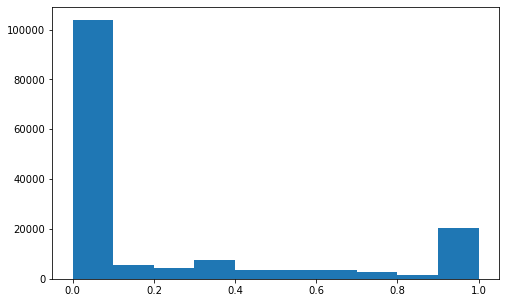

In [8]:
counts, bins = np.histogram(dat['V'])
plt.hist(bins[:-1], bins, weights=counts)

## Assumption Check

/var/folders/v4/1zbrx95516919mf320cfydlh0000gn/T/ipykernel_46626/1501333293.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  var_corr = dat.corr()


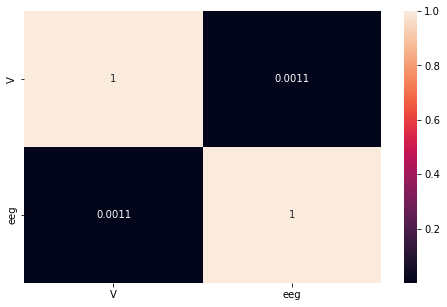

In [9]:
# get table of variable correlations
var_corr = dat.corr()
# plot the heatmap
sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, annot=True)
plt.show()

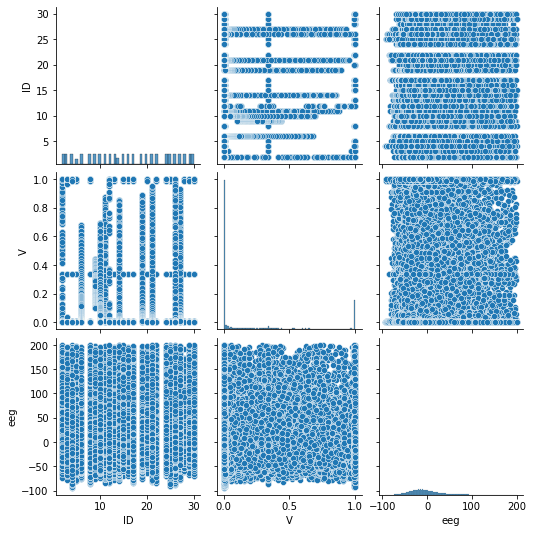

In [10]:
sns.pairplot(dat)

## EEG ~ V * f_t_el

In [11]:
# Performing an ordinary least squares (OLS) regression analysis, modeling 'eeg' as a function of 'V' and 'f_t_el',including their interaction ('V*f_t_el')
res = smf.ols('eeg ~ V*C(f_t_el, Sum)', data = dat).fit()

# Display the summary of the regression results (including coefficients, p-values, etc.).
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    eeg   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     75.33
Date:                Sun, 26 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:25:37   Log-Likelihood:            -7.9803e+05
No. Observations:              156008   AIC:                         1.596e+06
Df Residuals:                  155972   BIC:                         1.596e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -1.7519      0.120    -14.628      0.000      -1.987      -1.517
C(f_t_el, Sum)[S.Freq_f1_t1_el1]      10.0356      0.495     20.266      0.000       9.065      11.006
C(f_t_el, Sum)[S.Freq_f1_t1_el2]      11.0455      0.494     22.380      0.000      10.078      12.013
C(f_t_el, Sum)[S.Freq_f1_t2_el1]       3.3959      0.496      6.846      0.000       2.424       4.368
C(f_t_el, Sum)[S.Freq_f1_t2_el2]       1.4358      0.493      2.915      0.004       0.470       2.401
C(f_t_el, Sum)[S.Freq_f1_t3_el1]      -4.8004      0.496     -9.687      0.000      -5.772      -3.829
C(f_t_el, Sum)[S.Freq_f1_t3_el2]       1.0391      0.493      2.106      0.035       0.072       2.006
C(f_t_el, Sum)[S.Freq_f2_t1_el2]       1.1948      0.494      2.420      0.016       0.227       2.163
C(f_t_el, Sum)[S.Freq_f2_t1_el3]      -4.9120      0.495     -9.928      0.000      -5.882      -3.942
C(f_t_el, Sum)[S.Freq_f2_t2_el2]      -1.7225      0.494     -3.490      0.000      -2.690      -0.755
C(f_t_el, Sum)[S.Freq_f2_t2_el3]      -7.6299      0.495    -15.416      0.000      -8.600      -6.660
C(f_t_el, Sum)[S.Freq_f2_t3_el2]       0.8848      0.495      1.788      0.074      -0.085       1.855
C(f_t_el, Sum)[S.Freq_f2_t3_el3]      -1.6842      0.498     -3.382      0.001      -2.660      -0.708
C(f_t_el, Sum)[S.Freq_f3_t1_el2]       0.6203      0.492      1.260      0.208      -0.344       1.585
C(f_t_el, Sum)[S.Freq_f3_t1_el3]      -5.6088      0.492    -11.398      0.000      -6.573      -4.644
C(f_t_el, Sum)[S.Freq_f3_t2_el2]      -0.3506      0.492     -0.713      0.476      -1.315       0.614
C(f_t_el, Sum)[S.Freq_f3_t2_el3]      -0.9869      0.492     -2.007      0.045      -1.951      -0.023
C(f_t_el, Sum)[S.Freq_f3_t3_el2]      -0.8494      0.492     -1.727      0.084      -1.814       0.115
V                                      0.1379      0.288      0.479      0.632      -0.427       0.702
V:C(f_t_el, Sum)[S.Freq_f1_t1_el1]     5.3988      1.193      4.526      0.000       3.061       7.736
V:C(f_t_el, Sum)[S.Freq_f1_t1_el2]     6.1383      1.186      5.174      0.000       3.813       8.464
V:C(f_t_el, Sum)[S.Freq_f1_t2_el1]     5.2345      1.194      4.384      0.000       2.894       7.575
V:C(f_t_el, Sum)[S.Freq_f1_t2_el2]     2.5250      1.186      2.130      0.033       0.201       4.849
V:C(f_t_el, Sum)[S.Freq_f1_t3_el1]     1.0650      1.190      0.895      0.371      -1.268       3.398
V:C(f_t_el, Sum)[S.Freq_f1_t3_el2]    -0.7418      1.187     -0.625      0.532      -3.069       1.585
V:C(f_t_el, Sum)[S.Freq_f2_t1_el2]     3.1919      1.188      2.687      0.007       0.864       5.520
V:C(f_t_el, Sum)[S.Freq_f2_t1_el3]     6.0037      1.190      5.045      0.000       3.671      

In [12]:
# Extract the p-values from the OLS regression result.
p_values = res.pvalues 

# Perform multiple hypothesis testing correction on the p-values using the Benjamini-Hochberg method (FDR correction), with a significance level (alpha) of 0.05.
_, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(p_values, alpha=0.05, method='fdr_bh')

# Convert the original and corrected p-values to a DataFrame for better visualization.
df_stats = pd.DataFrame(res.summary().tables[1])
df_stats.set_index(df_stats.columns[0], inplace=True)
df_stats.columns = df_stats.iloc[0]
df_stats = df_stats[1:]
df_stats.insert(6, "corrected", pvals_corrected)


# Save the DataFrame with original and corrected p-values to an Excel file.
df_stats.to_excel("output_eeg_V-f_t_el.xlsx")
df_stats

,coef,std err,t,P>|t|,[0.025,0.975],corrected
0,,,,,,,
Intercept,-1.7519,0.120,-14.628,0.000,-1.987,-1.517,1.793847e-47
"C(f_t_el, Sum)[S.Freq_f1_t1_el1]",10.0356,0.495,20.266,0.000,9.065,11.006,6.094260e-90
"C(f_t_el, Sum)[S.Freq_f1_t1_el2]",11.0455,0.494,22.380,0.000,10.078,12.013,3.301280e-109
"C(f_t_el, Sum)[S.Freq_f1_t2_el1]",3.3959,0.496,6.846,0.000,2.424,4.368,3.432255e-11
"C(f_t_el, Sum)[S.Freq_f1_t2_el2]",1.4358,0.493,2.915,0.004,0.470,2.401,7.122174e-03
"C(f_t_el, Sum)[S.Freq_f1_t3_el1]",-4.8004,0.496,-9.687,0.000,-5.772,-3.829,1.781653e-21
"C(f_t_el, Sum)[S.Freq_f1_t3_el2]",1.0391,0.493,2.106,0.035,0.072,2.006,5.280419e-02
"C(f_t_el, Sum)[S.Freq_f2_t1_el2]",1.1948,0.494,2.420,0.016,0.227,2.163,2.662538e-02
"C(f_t_el, Sum)[S.Freq_f2_t1_el3]",-4.9120,0.495,-9.928,0.000,-5.882,-3.942,1.911267e-22


In [13]:
# Convert the original and corrected p-values to a DataFrame for better visualization.
df_stats = pd.DataFrame(res.summary().tables[0])
df_stats.set_index(df_stats.columns[0], inplace=True)
df_stats.columns = df_stats.iloc[0]
df_stats = df_stats[1:]
# Save the DataFrame to an Excel file.
df_stats.to_excel("output_model_param-eeg_V-f_t_el.xlsx", index = True)
df_stats

Dep. Variable:,eeg,R-squared:,0.017
0,,,
Model:,OLS,Adj. R-squared:,0.016
Method:,Least Squares,F-statistic:,75.33
Date:,"Sun, 26 Jan 2025",Prob (F-statistic):,0.00
Time:,16:25:49,Log-Likelihood:,-7.9803e+05
No. Observations:,156008,AIC:,1.596e+06
Df Residuals:,155972,BIC:,1.596e+06
Df Model:,35,,
Covariance Type:,nonrobust,,


### Assumption Check

**Check for Homoscedasticity**

Text(0, 0.5, 'residuals')

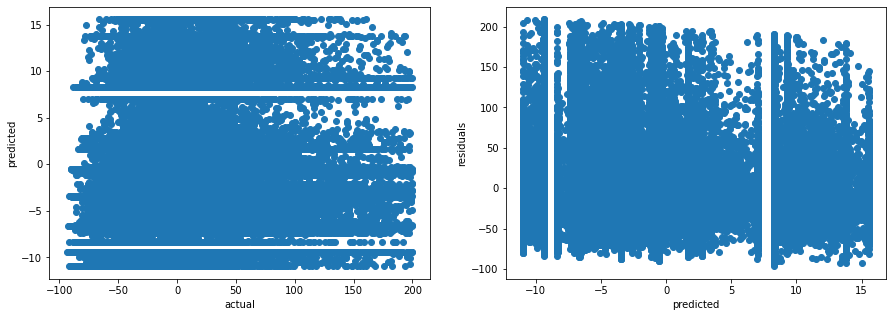

In [14]:
x_dat = dat[['V', 'f_t_el']]
y_dat = dat['eeg']


predicted = res.predict(x_dat)
residuals = y_dat - predicted

f, axs = plt.subplots(1, 2, figsize = [15,5])

axs[0].scatter(y_dat, predicted)
axs[0].set_xlabel('actual')
axs[0].set_ylabel('predicted')

axs[1].scatter(predicted, residuals)
axs[1].set_xlabel('predicted')
axs[1].set_ylabel('residuals')



**Check for Normality of residuals**

/var/folders/v4/1zbrx95516919mf320cfydlh0000gn/T/ipykernel_46626/1540356105.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals,kde=True)


Text(0.5, 1.0, 'Normality of error terms/residuals')

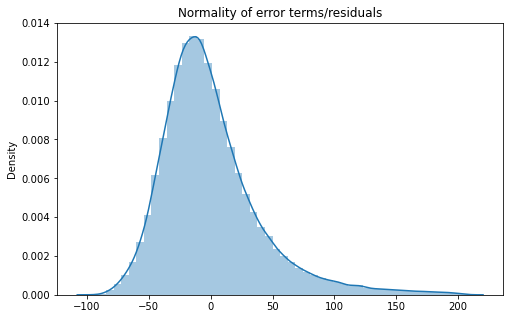

In [15]:
sns.distplot(residuals,kde=True)
plt.title('Normality of error terms/residuals')

/var/folders/v4/1zbrx95516919mf320cfydlh0000gn/T/ipykernel_46626/3223692276.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals,kde=True)


(-500.0, 500.0)

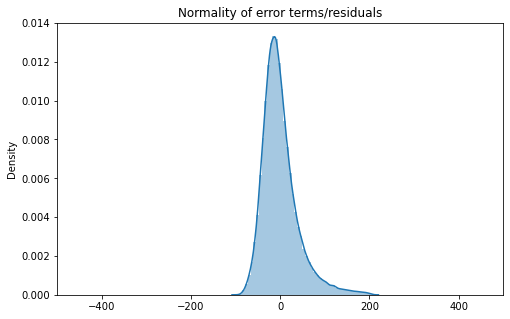

In [16]:
sns.distplot(residuals,kde=True)
plt.title('Normality of error terms/residuals')
plt.xlim(-500,500)

### EEG ~ V*congruency

In [17]:
# Performing an ordinary least squares (OLS) regression analysis for the extinction blocks, modeling 'eeg' as a function of 'V' and congruency including their interaction.
dat_cong = dat[~(dat['congruency'].values == 'nan')]
res = smf.ols("eeg ~ V* C(congruency, Treatment(reference = 'incongr'))", data = dat_cong).fit()

# Display the summary of the regression results (including coefficients, p-values, etc.).
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    eeg   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.219
Date:                Sun, 26 Jan 2025   Prob (F-statistic):             0.0217
Time:                        16:26:07   Log-Likelihood:            -3.1694e+05
No. Observations:               61807   AIC:                         6.339e+05
Df Residuals:                   61803   BIC:                         6.339e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                   -2.4908      0.254     -9.790      0.000      -2.989      -1.992
C(congruency, Treatment(reference='incongr'))[T.congr]      -0.4605      0.359     -1.283      0.200      -1.164       0.243
V                                                           -2.2533      1.260     -1.789      0.074      -4.722       0.215
V:C(congruency, Treatment(reference='incongr'))[T.congr]     5.5464      1.807      3.069      0.002       2.004       9.089
==============================================================================
Omnibus:                    16063.547   Durbin-Watson:                   1.638
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43865.755
Skew:                           1.389   Prob(JB):                         0.00
Kurtosis:                       6.052   Cond. No.                         14.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# Extract the p-values from the OLS regression result.
p_values = res.pvalues

# Perform multiple hypothesis testing correction on the p-values using the Benjamini-Hochberg method (FDR correction), with a significance level (alpha) of 0.05.
_, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(p_values, alpha=0.05, method='fdr_bh')

# Convert the original and corrected p-values to a DataFrame for better visualization.
df_stats = pd.DataFrame(res.summary().tables[1])
df_stats.set_index(df_stats.columns[0], inplace=True)
df_stats.columns = df_stats.iloc[0]
df_stats = df_stats[1:]
df_stats.insert(6, "corrected", pvals_corrected)

# Save the DataFrame with original and corrected p-values to an Excel file.
df_stats.to_excel("output_eeg_V-congruency.xlsx")
df_stats

,coef,std err,t,P>|t|,[0.025,0.975],corrected
0,,,,,,,
Intercept,-2.4908,0.254,-9.790,0.000,-2.989,-1.992,5.169139e-22
"C(congruency, Treatment(reference='incongr'))[T.congr]",-0.4605,0.359,-1.283,0.200,-1.164,0.243,1.996095e-01
V,-2.2533,1.260,-1.789,0.074,-4.722,0.215,9.816171e-02
"V:C(congruency, Treatment(reference='incongr'))[T.congr]",5.5464,1.807,3.069,0.002,2.004,9.089,4.300601e-03


In [20]:
# Convert the original and corrected p-values to a DataFrame for better visualization.
df_stats = pd.DataFrame(res.summary().tables[0])
df_stats.set_index(df_stats.columns[0], inplace=True)
df_stats.columns = df_stats.iloc[0]
df_stats = df_stats[1:]
# Save the DataFrame to an Excel file.
df_stats.to_excel("output_model_param-eeg_V-congruency.xlsx", index = True)
df_stats

Dep. Variable:,eeg,R-squared:,0.000
0,,,
Model:,OLS,Adj. R-squared:,0.000
Method:,Least Squares,F-statistic:,3.219
Date:,"Sun, 26 Jan 2025",Prob (F-statistic):,0.0217
Time:,16:28:22,Log-Likelihood:,-3.1694e+05
No. Observations:,61807,AIC:,6.339e+05
Df Residuals:,61803,BIC:,6.339e+05
Df Model:,3,,
Covariance Type:,nonrobust,,


### Assumption Check

**Check for Homoscedasticity**

Text(0, 0.5, 'residuals')

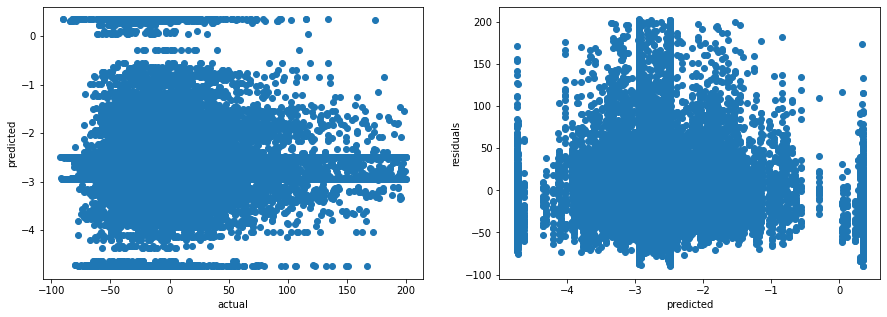

In [21]:
x_dat = dat_cong[['V', 'congruency']]
y_dat = dat_cong['eeg']


predicted = res.predict(x_dat)
residuals = y_dat - predicted

f, axs = plt.subplots(1, 2, figsize = [15,5])

axs[0].scatter(y_dat, predicted)
axs[0].set_xlabel('actual')
axs[0].set_ylabel('predicted')

axs[1].scatter(predicted, residuals)
axs[1].set_xlabel('predicted')
axs[1].set_ylabel('residuals')



**Check for Normality of residuals**

/var/folders/v4/1zbrx95516919mf320cfydlh0000gn/T/ipykernel_46626/1540356105.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals,kde=True)


Text(0.5, 1.0, 'Normality of error terms/residuals')

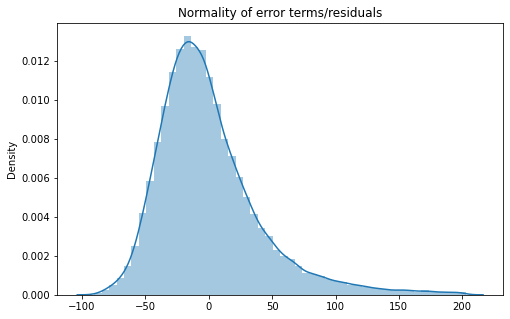

In [22]:
sns.distplot(residuals,kde=True)
plt.title('Normality of error terms/residuals')

/var/folders/v4/1zbrx95516919mf320cfydlh0000gn/T/ipykernel_46626/3223692276.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals,kde=True)


(-500.0, 500.0)

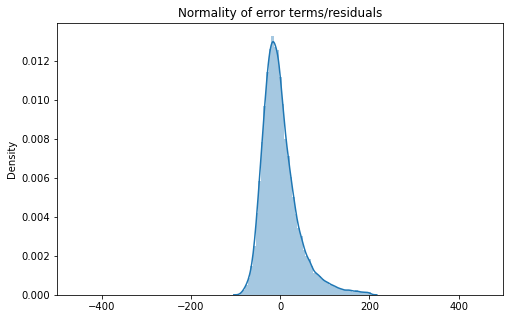

In [23]:
sns.distplot(residuals,kde=True)
plt.title('Normality of error terms/residuals')
plt.xlim(-500,500)

### EEG ~ V * f_t_el * congruency

In [24]:
# Performing an ordinary least squares (OLS) regression analysis for the extinction blocks, modeling 'eeg' as a function of 'V', 'f_t_el' and congruency including their interaction.
dat_cong = dat[~(dat['congruency'].values == 'nan')]
res = smf.ols("eeg ~ V*C(f_t_el, Sum)* C(congruency, Treatment(reference = 'incongr'))", data = dat_cong).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    eeg   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     12.71
Date:                Sun, 26 Jan 2025   Prob (F-statistic):          4.56e-143
Time:                        16:28:37   Log-Likelihood:            -3.1650e+05
No. Observations:               61807   AIC:                         6.331e+05
Df Residuals:                   61735   BIC:                         6.338e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================================
                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                    -2.4831      0.253     -9.824      0.000      -2.978      -1.988
C(f_t_el, Sum)[S.Freq_f1_t1_el1]                                                             10.7444      1.047     10.262      0.000       8.692      12.797
C(f_t_el, Sum)[S.Freq_f1_t1_el2]                                                             10.7355      1.043     10.294      0.000       8.692      12.780
C(f_t_el, Sum)[S.Freq_f1_t2_el1]                                                              2.6613      1.049      2.537      0.011       0.605       4.718
C(f_t_el, Sum)[S.Freq_f1_t2_el2]                                                              0.8488      1.040      0.816      0.414      -1.189       2.887
C(f_t_el, Sum)[S.Freq_f1_t3_el1]                                                             -5.8904      1.049     -5.617      0.000      -7.946      -3.835
C(f_t_el, Sum)[S.Freq_f1_t3_el2]                                                              0.2799      1.042      0.269      0.788      -1.763       2.323
C(f_t_el, Sum)[S.Freq_f2_t1_el2]                                                              1.3930      1.041      1.338      0.181      -0.648       3.434
C(f_t_el, Sum)[S.Freq_f2_t1_el3]                                                             -3.7618      1.043     -3.605      0.000      -5.807      -1.717
C(f_t_el, Sum)[S.Freq_f2_t2_el2]                                                             -2.0674      1.039     -1.990      0.047      -4.104      -0.031
C(f_t_el, Sum)[S.Freq_f2_t2_el3]                                                             -6.6896      1.044     -6.410      0.000      -8.735      -4.644
C(f_t_el, Sum)[S.Freq_f2_t3_el2]                                                              0.9296      1.043      0.891      0.373      -1.116       2.975
C(f_t_el, Sum)[S.Freq_f2_t3_el3]                                                             -0.8496      1.052     -0.808      0.419      -2.911       1.212
C(f_t_el, Sum)[S.Freq_f3_t1_el2]                                                             -0.0542      1.040     -0.052      0.958      -2.093       1.984
C(f_t_el, Sum)[S.Freq_f3_t1_el3]                                                             -5.6523      1.038     -5.446      0.000      -7.687      -3.618
C(f_t_el, Sum)[S.Freq_f3_t2_el2]                                                             -0.7019      1.037     -0.677      0.499      -2.735       1.331
C(f_t_el, Sum)[S.Freq_f3_t2_el3]                                                 

In [25]:
# Extract the p-values from the OLS regression result.
p_values = res.pvalues

# Perform multiple hypothesis testing correction on the p-values using the Benjamini-Hochberg method (FDR correction), with a significance level (alpha) of 0.05.
_, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(p_values, alpha=0.05, method='fdr_bh')

# Convert the original and corrected p-values to a DataFrame for better visualization.
df_stats = pd.DataFrame(res.summary().tables[1])
df_stats.set_index(df_stats.columns[0], inplace=True)
df_stats.columns = df_stats.iloc[0]
df_stats = df_stats[1:]
df_stats.insert(6, "corrected", pvals_corrected)


# Save the DataFrame with original and corrected p-values to an Excel file.
df_stats.to_excel("output_eeg_V-f_t_el-congruency.xlsx")
df_stats

,coef,std err,t,P>|t|,[0.025,0.975],corrected
0,,,,,,,
Intercept,-2.4831,0.253,-9.824,0.000,-2.978,-1.988,2.208730e-21
"C(f_t_el, Sum)[S.Freq_f1_t1_el1]",10.7444,1.047,10.262,0.000,8.692,12.797,3.943247e-23
"C(f_t_el, Sum)[S.Freq_f1_t1_el2]",10.7355,1.043,10.294,0.000,8.692,12.780,3.943247e-23
"C(f_t_el, Sum)[S.Freq_f1_t2_el1]",2.6613,1.049,2.537,0.011,0.605,4.718,5.755957e-02
"C(f_t_el, Sum)[S.Freq_f1_t2_el2]",0.8488,1.040,0.816,0.414,-1.189,2.887,8.156433e-01
...,...,...,...,...,...,...,...
"V:C(f_t_el, Sum)[S.Freq_f3_t1_el2]:C(congruency, Treatment(reference='incongr'))[T.congr]",-2.8011,7.395,-0.379,0.705,-17.295,11.692,9.062201e-01
"V:C(f_t_el, Sum)[S.Freq_f3_t1_el3]:C(congruency, Treatment(reference='incongr'))[T.congr]",-1.7759,7.388,-0.240,0.810,-16.256,12.704,9.284251e-01
"V:C(f_t_el, Sum)[S.Freq_f3_t2_el2]:C(congruency, Treatment(reference='incongr'))[T.congr]",3.1493,7.400,0.426,0.670,-11.356,17.654,8.776593e-01


In [26]:
# Convert the original and corrected p-values to a DataFrame for better visualization.
df_stats = pd.DataFrame(res.summary().tables[0])
df_stats.set_index(df_stats.columns[0], inplace=True)
df_stats.columns = df_stats.iloc[0]
df_stats = df_stats[1:]
# Save the DataFrame to an Excel file.
df_stats.to_excel("output_model_param-eeg_V-f_t_el-congruency.xlsx", index = True)
df_stats

Dep. Variable:,eeg,R-squared:,0.014
0,,,
Model:,OLS,Adj. R-squared:,0.013
Method:,Least Squares,F-statistic:,12.71
Date:,"Sun, 26 Jan 2025",Prob (F-statistic):,4.56e-143
Time:,16:28:43,Log-Likelihood:,-3.1650e+05
No. Observations:,61807,AIC:,6.331e+05
Df Residuals:,61735,BIC:,6.338e+05
Df Model:,71,,
Covariance Type:,nonrobust,,


### Assumption Check

**Check for Homoscedasticity**

Text(0, 0.5, 'residuals')

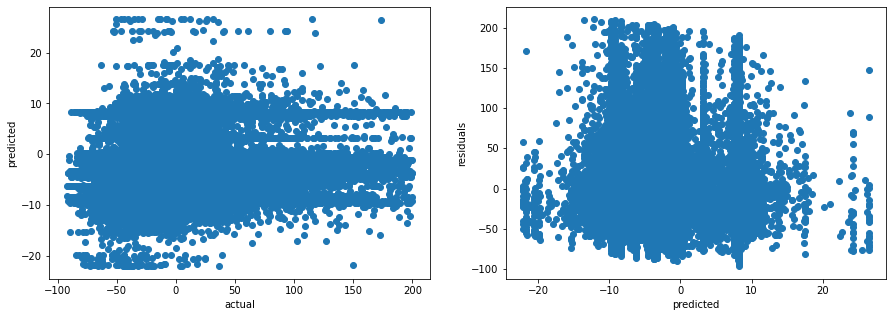

In [27]:
x_dat = dat_cong[['V', 'congruency', 'f_t_el']]
y_dat = dat_cong['eeg']


predicted = res.predict(x_dat)
residuals = y_dat - predicted

f, axs = plt.subplots(1, 2, figsize = [15,5])

axs[0].scatter(y_dat, predicted)
axs[0].set_xlabel('actual')
axs[0].set_ylabel('predicted')

axs[1].scatter(predicted, residuals)
axs[1].set_xlabel('predicted')
axs[1].set_ylabel('residuals')



**Check for Normality of residuals**

/var/folders/v4/1zbrx95516919mf320cfydlh0000gn/T/ipykernel_46626/1540356105.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals,kde=True)


Text(0.5, 1.0, 'Normality of error terms/residuals')

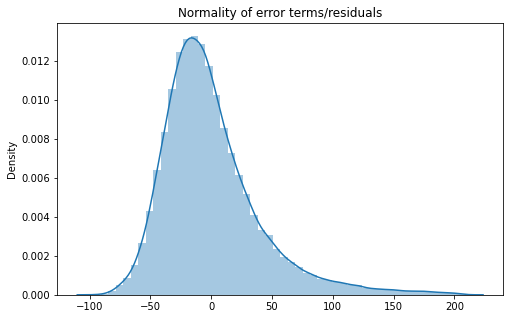

In [28]:
sns.distplot(residuals,kde=True)
plt.title('Normality of error terms/residuals')

/var/folders/v4/1zbrx95516919mf320cfydlh0000gn/T/ipykernel_46626/3223692276.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals,kde=True)


(-500.0, 500.0)

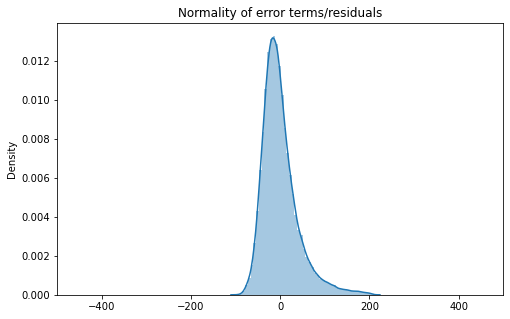

In [29]:
sns.distplot(residuals,kde=True)
plt.title('Normality of error terms/residuals')
plt.xlim(-500,500)